# synthetic data augmentation for approach 4

In [ ]:
# Synthetic tensor data generator 
import os, random, json
from tqdm import tqdm
from pathlib import Path
import torch
import torchvision.transforms.functional as TF
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import InterpolationMode

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
# Source real videos (per-class subfolders)
orig_train_root = "../data_split/train"  # adjust if your real data is elsewhere

# new synthetic data path
synthetic_root  = "../synthetic"        # changed root; not inside ../data
classes = ["forehand","backhand","serves","nostroke"]

frames_per_clip = 16
out_h, out_w = 112, 112
n_per_clip = 3  # number of synthetic variants per real clip
device = "cpu"  # generation runs on CPU (tensors saved)

os.makedirs(synthetic_root, exist_ok=True)
for c in classes:
    os.makedirs(os.path.join(synthetic_root, c), exist_ok=True)

In [ ]:
#  Augmenter (operates on clip tensor in [0,1] range) 
def synthesize_augment_tensor(clip, prob_temporal_jitter=0.6, prob_speed=0.5, prob_spatial=0.8):

   # clip: torch tensor [3, T, H, W] values in [0,1] returns augmented clip same shape [3, T, H, W]
    clip = clip.clone()
    C,T,H,W = clip.shape

    # temporal jitter: drop/duplicate small number of frames
    if random.random() < prob_temporal_jitter:
        drop_n = random.choice([0,1,2])
        if drop_n>0 and T-drop_n>0:
            idxs = list(range(T))
            drop_idx = sorted(random.sample(idxs, drop_n))
            new_frames = []
            for i in range(T):
                if i in drop_idx:
                    continue
                new_frames.append(clip[:,i,:,:])
            while len(new_frames) < T:
                new_frames.append(new_frames[-1].clone())
            clip = torch.stack(new_frames[:T], dim=1)

    # speed change: resample frames with linear interpolation
    if random.random() < prob_speed:
        speed = random.choice([0.7, 0.85, 1.0, 1.15, 1.3])  # slow/fast
        new_len = max(2, int(round(T / speed)))
        idxs = np.linspace(0, T-1, new_len)
        new_frames = []
        for x in idxs:
            i0 = int(np.floor(x)); i1 = min(i0+1, T-1)
            w = x - i0
            f = (1-w)*clip[:,i0,:,:] + w*clip[:,i1,:,:]
            new_frames.append(f)
        if len(new_frames) < T:
            while len(new_frames) < T:
                new_frames.append(new_frames[-1].clone())
        clip = torch.stack(new_frames[:T], dim=1)

    # spatial affine + color jitter applied consistently to all frames
    if random.random() < prob_spatial:
        angle = random.uniform(-10, 10)
        translate = (int(random.uniform(-0.05,0.05)*W), int(random.uniform(-0.05,0.05)*H))
        scale = random.uniform(0.95,1.05)
        shear = random.uniform(-5,5)
        frames = []
        for t in range(T):
            img = TF.to_pil_image(clip[:,t,:,:].cpu())
            img = TF.affine(img,angle=angle,
    translate=translate,
    scale=scale,
    shear=shear,
    interpolation=InterpolationMode.BILINEAR,
    fill=0
)
            if random.random() < 0.35:
                img = TF.adjust_brightness(img, random.uniform(0.9,1.1))
                img = TF.adjust_contrast(img, random.uniform(0.9,1.1))
            frames.append(TF.to_tensor(img))
        clip = torch.stack(frames, dim=1).to(clip.device)

    # slight gaussian noise
    if random.random() < 0.3:
        noise = torch.randn_like(clip) * (0.01 * random.random())
        clip = torch.clamp(clip + noise, 0.0, 1.0)

    return clip

In [ ]:
#helper to load a video and return normalized clip tensor [3,T,H,W] in [0,1]
def load_video_as_tensor(video_path, frames_per_clip=frames_per_clip, out_size=(out_w,out_h)):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 1
    idxs = np.linspace(0, total-1, frames_per_clip, dtype=int)
    frames = []
    last_valid = None
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
        ret, frame = cap.read()
        if not ret:
            if last_valid is not None:
                frame = last_valid.copy()
            else:
                frame = np.zeros((out_h, out_w, 3), dtype=np.uint8)
        else:
            last_valid = frame.copy()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, out_size)
        frames.append(frame)
    cap.release()
    # to tensor [T,C,H,W]
    arr = np.stack(frames, axis=0).astype(np.float32) / 255.0
    tensor = torch.from_numpy(arr).permute(3,0,1,2)  # [C,T,H,W]
    return tensor

In [ ]:
# data generation loop
manifest = {"classes": {}, "total_real": 0, "total_synthetic": 0, "seed": random_seed}
for cls in classes:
    src_dir = os.path.join(orig_train_root, cls)
    if not os.path.isdir(src_dir):
        print(f"[WARN] source dir not found: {src_dir} - skipping")
        manifest["classes"][cls] = {"real": 0, "synthetic": 0}
        continue

    video_files = sorted([f for f in os.listdir(src_dir) if f.endswith(".mp4")])
    n_real = len(video_files)
    manifest["classes"][cls] = {"real": n_real, "synthetic": 0, "files": []}
    for vfn in tqdm(video_files, desc=f"Creating synth for {cls}", leave=False):
        real_path = os.path.join(src_dir, vfn)
        # load real clip as tensor
        try:
            clip = load_video_as_tensor(real_path, frames_per_clip=frames_per_clip, out_size=(out_w,out_h))
        except Exception as e:
            print(f"[ERROR] failed to load {real_path}: {e}")
            continue
        # save metadata for the real file
        manifest["classes"][cls]["files"].append(vfn)
        manifest["total_real"] = manifest.get("total_real",0) + 1
        # create N synthetic variants per clip
        base_name = Path(vfn).stem
        for k in range(n_per_clip):
            syn = synthesize_augment_tensor(clip)   # [C,T,H,W], float in [0,1]
            # save path
            out_name = f"{base_name}__syn{k+1}.pt"
            out_path = os.path.join(synthetic_root, cls, out_name)
            torch.save(syn, out_path)
            manifest["classes"][cls]["synthetic"] += 1
            manifest["total_synthetic"] = manifest.get("total_synthetic",0) + 1

# write manifest json
manifest_path = os.path.join(synthetic_root, "manifest.json")
with open(manifest_path, "w") as f:
    json.dump(manifest, f, indent=2)

print("SYNTHETIC GENERATION COMPLETE")
print("manifest:", manifest_path)
print("Totals:", "real=", manifest.get("total_real",0), "synthetic=", manifest.get("total_synthetic",0))

In [ ]:
from torch.utils.data import Dataset, ConcatDataset, DataLoader

class SyntheticTensorDataset(Dataset):
    def __init__(self, synthetic_root, classes, transform=None):
        # collects all .pt files under synthetic_root/<class>/
        self.samples = []
        for cls in classes:
            d = os.path.join(synthetic_root, cls)
            if not os.path.isdir(d): continue
            for fn in sorted(os.listdir(d)):
                if fn.endswith(".pt"):
                    self.samples.append((os.path.join(d, fn), classes.index(cls)))
        self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        clip = torch.load(path)  # [C,T,H,W] in [0,1]
        if self.transform:
            clip = self.transform(clip)
        return clip, label

def visualize_synthetic_pt(pt_path, n_frames=8):
# loads a saved .pt tensor and shows first n_frames evenly spaced.

    clip = torch.load(pt_path)  # [C,T,H,W] in [0,1]
    _, T, H, W = clip.shape
    idxs = np.linspace(0, T-1, n_frames, dtype=int)
    plt.figure(figsize=(12,3))
    for i, t in enumerate(idxs):
        img = clip[:,t,:,:].permute(1,2,0).numpy()
        img = np.clip(img*255, 0, 255).astype(np.uint8)
        plt.subplot(1, n_frames, i+1); plt.imshow(img); plt.axis('off')
    plt.show()

# Example usage:
# synth_dataset = SyntheticTensorDataset("../synthetic", classes)
# mixed_dataset = ConcatDataset([real_dataset, synth_dataset])   # if you have real_dataset
# loader = DataLoader(synth_dataset, batch_size=4, shuffle=True)
# visualize_synthetic_pt("../synthetic/forehand/some_video__syn1.pt")

print("Helper classes ready — synthetic tensors are in:", synthetic_root)


Creating synth for serves:   0%|          | 0/16 [00:00<?, ?it/s]           [h264 @ 0x14a9d0480] mmco: unref short failure
[h264 @ 0x14a9d0480] mmco: unref short failure
[h264 @ 0x14a9d0480] mmco: unref short failure
[h264 @ 0x14a9d0480] mmco: unref short failure
[h264 @ 0x14a9d0480] mmco: unref short failure
[h264 @ 0x14a9d0480] mmco: unref short failure
[h264 @ 0x14a9d0480] mmco: unref short failure
[h264 @ 0x14a9d0480] mmco: unref short failure
Creating synth for serves:   6%|▋         | 1/16 [00:00<00:06,  2.44it/s][h264 @ 0x14ad79620] mmco: unref short failure
[h264 @ 0x14ad79620] mmco: unref short failure
[h264 @ 0x14ad79620] mmco: unref short failure
[h264 @ 0x14ad79620] mmco: unref short failure
[h264 @ 0x14ad79620] mmco: unref short failure
[h264 @ 0x14ad79620] mmco: unref short failure
[h264 @ 0x14ad79620] mmco: unref short failure
[h264 @ 0x14ad79620] mmco: unref short failure
Creating synth for serves:  12%|█▎        | 2/16 [00:00<00:05,  2.47it/s][h264 @ 0x116ee0b50] mmco:

SYNTHETIC GENERATION COMPLETE
manifest: ../synthetic/manifest.json
Totals: real= 80 synthetic= 240
Helper classes ready — synthetic tensors are in: ../synthetic


example: [PosixPath('../synthetic/forehand/FH_4__syn2.pt'), PosixPath('../synthetic/forehand/FH_19__syn2.pt'), PosixPath('../synthetic/forehand/FH_13__syn2.pt'), PosixPath('../synthetic/forehand/FH_16__syn1.pt'), PosixPath('../synthetic/forehand/FH_13__syn3.pt')]


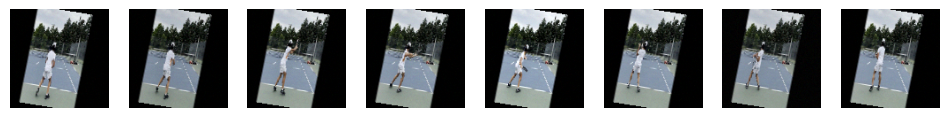

In [4]:
# visualize a few saved synthetic clips
from pathlib import Path
import random
p = Path("../synthetic/forehand")
files = list(p.glob("*.pt"))
print("example:", files[:5])
# show one
visualize_synthetic_pt(str(files[0]), n_frames=8)   # uses helper from previous cell
